In [1]:
import numpy as np
import sympy as sp
import qutip as qt
import matplotlib.pyplot as plt
from scipy import constants as const
from scipy.optimize import minimize_scalar

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si
from boson_helpers import*

In [2]:
def solve_hub(J,U,Delta,mu,V,DeltaJ,tau,
              N_steps=1000, initial_occ=[1,1]):
    """
    Solves and evolves (duration of tau) the Hubbard-Hamiltonian for the given
    parameters and ramping. Input parameters as angular frequencies and U,Delta
    as tuple of start and end value.
    """
    # Maximum boson number per site (Hilbert space dimension d = Nmax+1)
    Nmax = initial_occ[0] + initial_occ[1]
    d = Nmax + 1

    # --- Define Operators ---
    # Single-site bosonic operators in the truncated Fock space
    a = qt.destroy(d)
    adag = a.dag()
    n_op = adag * a

    # --- Construct Hamiltonian ---
    # Hopping term: -J (a† ⊗ a + a ⊗ a†)
    H_hop = -J* (qt.tensor(adag, a) + qt.tensor(a, adag))

    # Interaction term: (U/2) * [n(n-1)] on each site
    # We subtract the identity appropriately to compute n(n-1)
    H_int = 0.5*(qt.tensor(n_op * (n_op - qt.qeye(d)), qt.qeye(d)) +
                    qt.tensor(qt.qeye(d), n_op * (n_op - qt.qeye(d))))
    # Define the time-dependent function for the interaction
    def int_func(t, args):
        return args['U0']+ (args['U1']-args['U0'])* t/args['tau']
    int_args = {'U0': U[0], 'U1': U[1], 'tau': tau}
    
    # Chemical potential term (if desired)
    H_mu = -mu* (qt.tensor(n_op, qt.qeye(d)) + qt.tensor(qt.qeye(d), n_op))

    #tilt potential
    H_tilt = (1*qt.tensor(n_op, qt.qeye(d)) + 2*qt.tensor(qt.qeye(d), n_op))
    # Define the time-dependent function for the tilt
    def tilt_func(t, args):
        return args['D0']+ (args['D1']-args['D0'])* t/args['tau']
    tilt_args = {'D0': Delta[0], 'D1': Delta[1], 'tau': tau}

    #nearest neighbour interaction
    H_nni = V* qt.tensor(n_op, qt.qeye(d)) * qt.tensor(qt.qeye(d), n_op)

    #density induced tunneling
    H_dit = -DeltaJ* (qt.tensor(adag,a)* (qt.tensor(n_op,qt.qeye(d)) + qt.tensor(n_op,qt.qeye(d)) - 1) +
                        qt.tensor(a,adag)* (qt.tensor(n_op,qt.qeye(d)) + qt.tensor(n_op,qt.qeye(d)) - 1))


    # Total Hamiltonian
    H_static = H_hop + H_mu + H_nni + H_dit
    H = [H_static, [H_int, int_func],[H_tilt, tilt_func]]
    


    # --- Define Initial State ---
    # The product Fock state |1,1> (one boson per site)
    psi0 = qt.tensor(qt.basis(d, initial_occ[0]), qt.basis(d, initial_occ[1]))

    # --- Time Evolution Setup ---
    tlist = np.linspace(0, tau, N_steps)  # Evolve from time 0 to 5 in 101 steps

    # We want to monitor the number operator expectation values at each site.
    e_ops = [qt.tensor(n_op, qt.qeye(d)), qt.tensor(qt.qeye(d), n_op)]

    # Create an Options object with store_states=True
    #opts = qt.Options(store_states=True, nsteps=10000)
    opts = {"store_states": True, "nsteps": 10000}

    # Run the evolution and store the full state history
    result = qt.sesolve(H, psi0, tlist, e_ops=e_ops, options=opts,
                        args=int_args | tilt_args)
    
    return tlist, result

# Import results from diagonalisation

In [3]:
start_line = 338
end_line = start_line

n_lines = end_line - start_line + 1
lines = np.arange(start_line,end_line+1,dtype=int)
state_nrs = np.zeros((n_lines,2),dtype=int)
state_nrs[:,1] = 1

degeneracy = np.full(n_lines, True, dtype=bool)

line: 338
separation: 0.7454 um


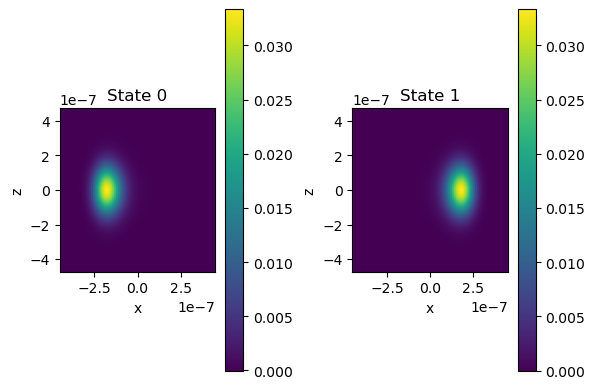

In [4]:
for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]
    
    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    print(f"line: {line}")
    print(f"separation: {trap.subs(trap.distance_tweezers)/si.um:.4f} um")

    #plot wavefunctions
    n_states = 2

    states_plot = [GS_left_1.real, GS_right_1.real]
    #states_plot = [res["states"][state0].real, res["states"][state1].real]
    #states_plot = np.angle(states)
    #states_plot = states.imag
    #states_plot = np.abs(states)**2

    # Create a 1xn_states grid of subplots (1 row, n_states columns)
    fig, axes = plt.subplots(1, n_states, figsize=(6, 4))  # Adjust the size as needed

    # Loop over the state numbers from 0 to n_states-1
    for state_number, ax in zip(range(n_states), axes):
        # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
        im = ax.imshow(states_plot[state_number][:, int(res["size"][1]/2), :].T,
                    extent=[*res["extend"][0], *res["extend"][2]], origin="lower",
                    vmin=np.min(states_plot[state_number]), vmax=np.max(states_plot[state_number]))

        # Set labels for each subplot
        ax.set_xlabel("x")
        ax.set_ylabel("z")
        ax.set_title(f"State {state_number}")
        fig.colorbar(im, ax=ax)  

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [5]:
frequencies = np.zeros_like(lines,dtype=float)
distance = np.zeros_like(lines,dtype=float)
J = np.zeros_like(lines,dtype=float)
#tilt = np.zeros_like(lines,dtype=float)
U_s = np.zeros_like(lines,dtype=float)
U_dds = np.zeros((len(lines),50),dtype=float)
angles = np.zeros((len(lines),50),dtype=float)
V_lrs = np.zeros((len(lines),50),dtype=float)
DeltaJs = np.zeros((len(lines),50),dtype=float)

E_exc = np.zeros_like(lines,dtype=float)
E_barr = np.zeros_like(lines,dtype=float)

for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]

    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    frequencies[i] = float(trap.subs(sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m) * 2/trap.waist_tweezer1**2))
    distance[i] = float(trap.subs(trap.distance_tweezers))
    J[i], U_s[i], U_dds[i], angles[i], V_lrs[i], DeltaJs[i] = analyse_diagonalisation(line,
                                                                state_nr0=state0,
                                                                state_nr1=state1,
                                                                degenerate=degeneracy[i],
                                                                n_angles=20)
    
    #estimate energies of 0th and 1st state
    E0 = 0.5*(res["energies"][0] + res["energies"][1])
    E1 = 0.5*(res["energies"][2] + res["energies"][3])
    E_exc[i] = E1-E0

    #estimate heigth of barrier
    V = trap.subs(trap.get_potential(apply_zero_offset=False))
    a = float(trap.subs(trap.distance_tweezers))

    #find minima of potential
    def V_func(x):
        return float(V.subs({trap.x:x, trap.y:0, trap.z:0}))

    x_right = minimize_scalar(V_func,bracket=[0,a]).x
    x_left = minimize_scalar(V_func,bracket=[-a,0]).x

    #catch case where both potentials have already merged
    tunneling_dist = abs(x_right-x_left)
    if tunneling_dist < 1e-15:
        raise Exception("potential has only one minmum")

    #depts of both tweezers
    V_1 = abs(V_func(x_left) - V_func(0))
    V_2 = abs(V_func(x_right) - V_func(0)) 

    E_barr[i] = np.max([V_1,V_2])

    # these states are basically 1 tweezer
    if state1 !=1:
        J[i] = np.nan
        U_s[i] = np.nan
        U_dds[i] = np.nan
        V_lrs[i] = np.nan
        DeltaJs[i] = np.nan
        E_exc[i] = np.nan
        E_barr[i] = np.nan

d = [745.43444684] nm
omega_x = [50000.] Hz
J = [10.32670994] Hz
U_s = [1258.25386365] Hz
E_exc = [6875.56532084] Hz
E_barr = [40535.07317535] Hz


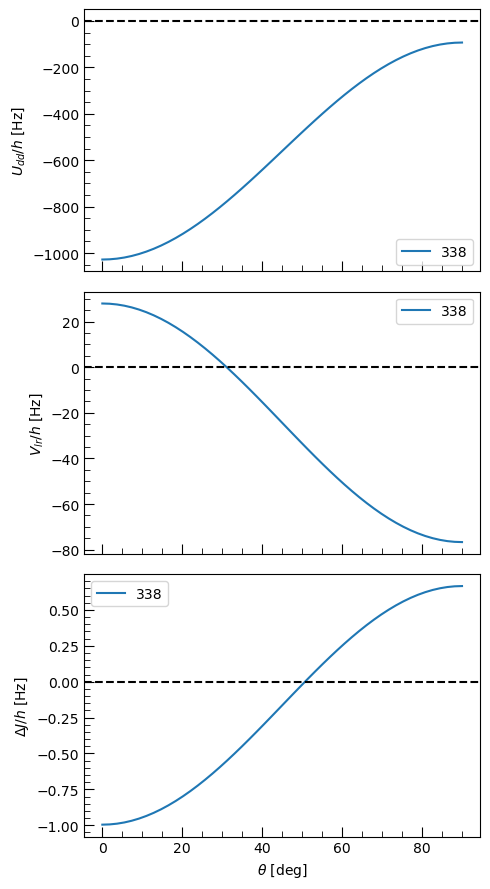

In [6]:
print(f"d = {distance/si.nm} nm")
print(f"omega_x = {frequencies/2/np.pi} Hz")
print(f"J = {J/const.h} Hz")
print(f"U_s = {U_s/const.h} Hz")
print(f"E_exc = {E_exc/const.h} Hz")
print(f"E_barr = {E_barr/const.h} Hz")

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(5, 9), sharex=True)

for i, line in enumerate(lines):
    # Plot U_dd
    axes[0].plot(np.rad2deg(angles[i]), U_dds[i]/const.h,label=f"{line}")
    axes[0].axhline(0, color="black", ls="--")
    axes[0].set_ylabel(r"$U_{dd} / h$ [Hz]")
    axes[0].legend()

    # Plot NNI
    axes[1].plot(np.rad2deg(angles[i]), V_lrs[i]/const.h,label=f"{line}")
    axes[1].axhline(0, color="black", ls="--")
    axes[1].set_ylabel(r"$V_{lr} / h$ [Hz]")
    axes[1].legend()

    # Plot DIT
    axes[2].plot(np.rad2deg(angles[i]), DeltaJs[i]/const.h,label=f"{line}")
    axes[2].axhline(0, color="black", ls="--")
    axes[2].set_xlabel(r"$\theta$ [deg]")
    axes[2].set_ylabel(r"$\Delta J / h$ [Hz]")
    axes[2].legend()

    # Customize ticks for all subplots
    for ax in axes:
        ax.tick_params(axis='both', which='both', direction='in', length=5)  # Tick marks inside
        ax.tick_params(axis='both', which='major', length=7)  # Major ticks longer
        ax.tick_params(axis='both', which='minor', length=4)  # Minor ticks shorter
        ax.minorticks_on()  # Enable minor ticks

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Ramping scheme for different populations:

Setting nearest-neighbour interactions and density-induced tunneling to 0 for convenicence

## N=2

d: 745.43 nm
omega_x: 50000.00 Hz
J: 10.33 Hz
limits set by: 1st excited state = 687.56 Hz, barrier = 4053.51 Hz, interactions = 4310.78 Hz
=> max. tilt/interaction: 687.56 Hz
J/U = 0.0300
V: 0.00 Hz
DeltaJ: 0.00 Hz
ramp time: 968.363 ms
fidelity: 0.99449


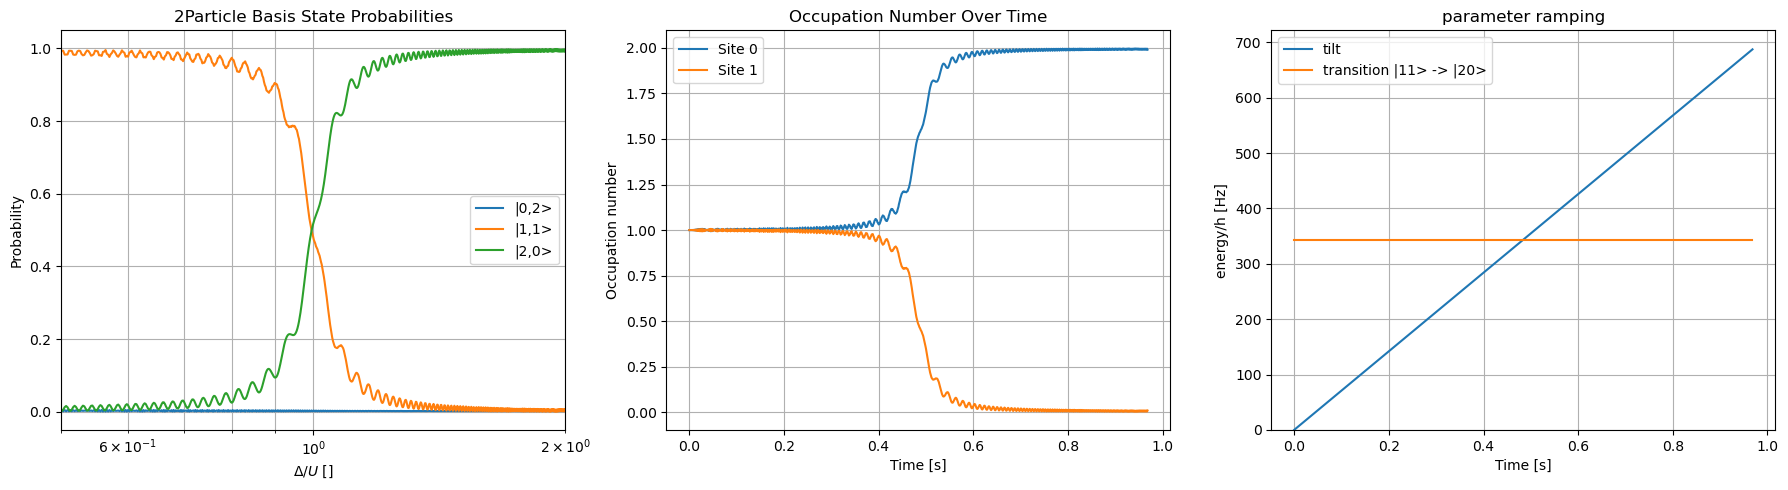

In [127]:
n = 2

initial_occ=np.array([n-1,1])

#maximum energy scale for ramp
#assuming that staying below 25% of the 1st excited state is enough
#and the contact scattering length can be tuned from 0 to 3.5* 85a0
limits = np.array([E_exc[0]/10,
                   E_barr[0]/10,
                   U_s[0]*3.5 + np.max(U_dds)])
E_max = np.min(limits)/const.hbar

# --- Parameters ---
J_freq = J[0]/const.hbar      # Hopping amplitude
U = (E_max/n, E_max/n)       # On-site interaction strength
Delta = ((n-2)*U[0], n*U[0])        #tilt

mu = 0.0      # Chemical potential (set to zero for simplicity)
# V = V_lrs.max()/const.hbar    # nearest neighbour interaction energy (due to DDI)
# DeltaJ = DeltaJs.max()/const.hbar   # density induced tunneling
V = 0
DeltaJ = 0

tau = 2*np.pi/J_freq *10    #take 10 times the time scale set by J for evolution
N_steps = int(1e3)      #number of timesteps

print(f"d: {distance[0]/si.nm:.2f} nm")
print(f"omega_x: {frequencies[0]/2/np.pi:.2f} Hz")
print(f"J: {J_freq/2/np.pi:.2f} Hz")
print(f"limits set by: 1st excited state = {limits[0]/const.h:.2f} Hz, barrier = {limits[1]/const.h:.2f} Hz, interactions = {limits[2]/const.h:.2f} Hz")
print(f"=> max. tilt/interaction: {E_max/2/np.pi:.2f} Hz")
print(f"J/U = {J_freq/U[0]:.4f}")
print(f"V: {V/2/np.pi:.2f} Hz")
print(f"DeltaJ: {DeltaJ/2/np.pi:.2f} Hz")
print(f"ramp time: {tau/si.ms:.3f} ms")

tlist, result = solve_hub(J_freq,U,Delta, mu,V,DeltaJ,tau,N_steps=N_steps,
                          initial_occ=initial_occ)

d= n + 1

# --- Extracting and Plotting State Vector Components ---
# Create an array of states; each state is flattened into a 1D array of length d^2
states = np.array([state.full().flatten() for state in result.states])
# Compute probabilities: squared magnitude of each component
probs = np.abs(states)**2

# Create labels for each basis state in the two-site Fock space
basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
# Create a list of corresponding total particle numbers for each basis state
total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

# Filter indices for basis states with exactly 2 particles
indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == np.sum(initial_occ)]
labels_2particles = [basis_labels[idx] for idx in indices_2particles]

#fidelity as the probability for |2,0> in the last 10% of steps
#calculate fidelity
fid  = np.mean(probs[int(0.9*len(tlist)):,indices_2particles[-1]])
print(f"fidelity: {fid:.5f}")

#alternatively with ratio Delta/U
interactions = np.linspace(U[0],U[1],len(tlist))
tilt = np.linspace(Delta[0],Delta[1],len(tlist))
ratio = tilt/interactions

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Probability of 2-particle basis states ---
for idx, label in zip(indices_2particles, labels_2particles):
    axs[0].plot(ratio[:int(1*len(tlist))], probs[:, idx][:int(1*len(tlist))], label=label)
axs[0].set_xscale("log")
axs[0].set_xlim(0.5,2)
axs[0].set_xlabel(r'$\Delta /U$ []')
axs[0].set_ylabel('Probability')
axs[0].set_title(f'{n}Particle Basis State Probabilities')
axs[0].legend()
axs[0].grid(which="both")

# --- Plot 2: Occupation number vs time ---
axs[1].plot(tlist, result.expect[0], label='Site 0')
axs[1].plot(tlist, result.expect[1], label='Site 1')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Occupation number')
axs[1].set_title('Occupation Number Over Time')
axs[1].legend()
axs[1].grid(True)

# --- Plot 3: Energies vs time ---
axs[2].plot(tlist, np.linspace(Delta[0]/2/np.pi, Delta[1]/2/np.pi, N_steps), label="tilt")

axs[2].plot(tlist, (1*U[0] - 0*U[0])/2/np.pi*np.ones(N_steps), label="transition |11> -> |20>")

axs[2].set_ylim(bottom=0)
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('energy/h [Hz]')
axs[2].set_title('parameter ramping')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


## N=3

d: 745.43 nm
omega_x: 50000.00 Hz
J: 10.33 Hz
limits set by: 1st excited state = 687.56 Hz, barrier = 4053.51 Hz, interactions = 4310.78 Hz
=> max. tilt/interaction: 687.56 Hz
J/U = 0.0451
V: 0.00 Hz
DeltaJ: 0.00 Hz
ramp time: 968.363 ms
fidelity: 0.98069


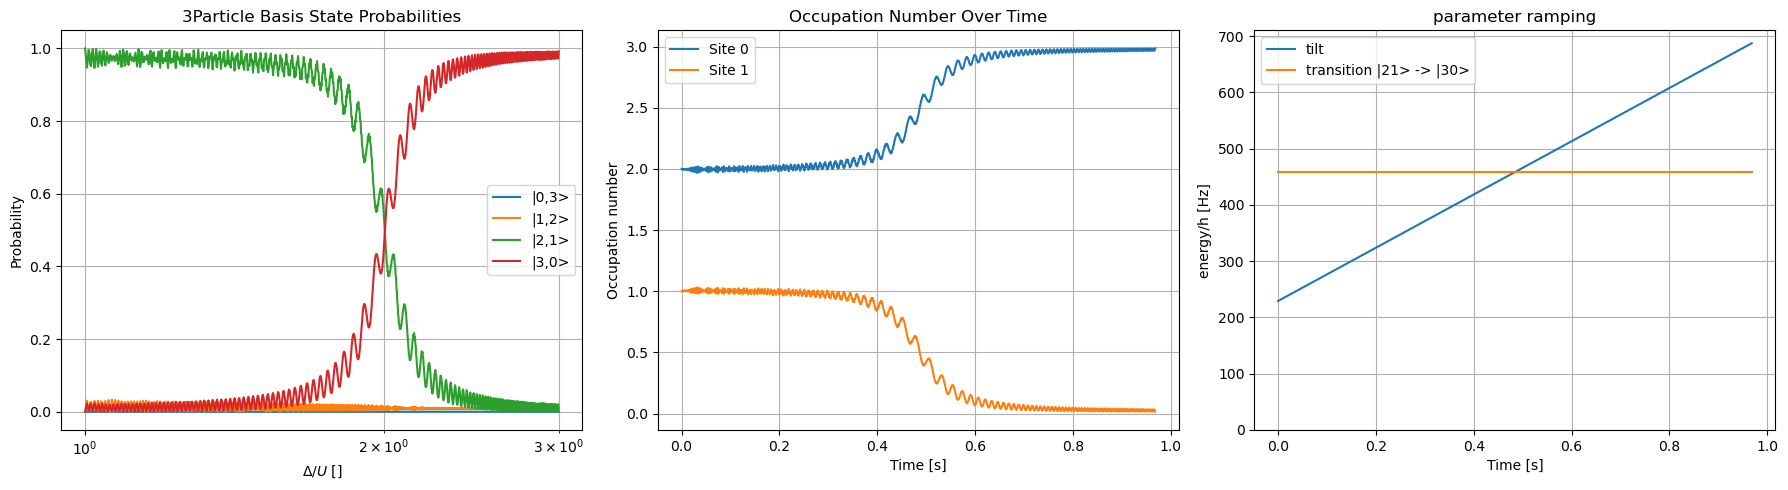

In [128]:
n = 3

initial_occ=np.array([n-1,1])

#maximum energy scale for ramp
#assuming that staying below 25% of the 1st excited state is enough
#and the contact scattering length can be tuned from 0 to 3.5* 85a0
limits = np.array([E_exc[0]/10,
                   E_barr[0]/10,
                   U_s[0]*3.5 + np.max(U_dds)])
E_max = np.min(limits)/const.hbar

# --- Parameters ---
J_freq = J[0]/const.hbar      # Hopping amplitude
U = (E_max/n, E_max/n)       # On-site interaction strength
Delta = ((n-2)*U[0], n*U[0])        #tilt

mu = 0.0      # Chemical potential (set to zero for simplicity)
# V = V_lrs.max()/const.hbar    # nearest neighbour interaction energy (due to DDI)
# DeltaJ = DeltaJs.max()/const.hbar   # density induced tunneling
V = 0
DeltaJ = 0

tau = 2*np.pi/J_freq *10    #take 10 times the time scale set by J for evolution
N_steps = int(1e3)      #number of timesteps

print(f"d: {distance[0]/si.nm:.2f} nm")
print(f"omega_x: {frequencies[0]/2/np.pi:.2f} Hz")
print(f"J: {J_freq/2/np.pi:.2f} Hz")
print(f"limits set by: 1st excited state = {limits[0]/const.h:.2f} Hz, barrier = {limits[1]/const.h:.2f} Hz, interactions = {limits[2]/const.h:.2f} Hz")
print(f"=> max. tilt/interaction: {E_max/2/np.pi:.2f} Hz")
print(f"J/U = {J_freq/U[0]:.4f}")
print(f"V: {V/2/np.pi:.2f} Hz")
print(f"DeltaJ: {DeltaJ/2/np.pi:.2f} Hz")
print(f"ramp time: {tau/si.ms:.3f} ms")

tlist, result = solve_hub(J_freq,U,Delta, mu,V,DeltaJ,tau,N_steps=N_steps,
                          initial_occ=initial_occ)

d= n + 1

# --- Extracting and Plotting State Vector Components ---
# Create an array of states; each state is flattened into a 1D array of length d^2
states = np.array([state.full().flatten() for state in result.states])
# Compute probabilities: squared magnitude of each component
probs = np.abs(states)**2

# Create labels for each basis state in the two-site Fock space
basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
# Create a list of corresponding total particle numbers for each basis state
total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

# Filter indices for basis states with exactly 2 particles
indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == np.sum(initial_occ)]
labels_2particles = [basis_labels[idx] for idx in indices_2particles]

#fidelity as the probability for |2,0> in the last 10% of steps
#calculate fidelity
fid  = np.mean(probs[int(0.9*len(tlist)):,indices_2particles[-1]])
print(f"fidelity: {fid:.5f}")

#alternatively with ratio Delta/U
interactions = np.linspace(U[0],U[1],len(tlist))
tilt = np.linspace(Delta[0],Delta[1],len(tlist))
ratio = tilt/interactions

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Probability of 2-particle basis states ---
for idx, label in zip(indices_2particles, labels_2particles):
    axs[0].plot(ratio[:int(1*len(tlist))], probs[:, idx][:int(1*len(tlist))], label=label)
axs[0].set_xscale("log")
axs[0].set_xlabel(r'$\Delta /U$ []')
axs[0].set_ylabel('Probability')
axs[0].set_title(f'{n}Particle Basis State Probabilities')
axs[0].legend()
axs[0].grid(which="both")

# --- Plot 2: Occupation number vs time ---
axs[1].plot(tlist, result.expect[0], label='Site 0')
axs[1].plot(tlist, result.expect[1], label='Site 1')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Occupation number')
axs[1].set_title('Occupation Number Over Time')
axs[1].legend()
axs[1].grid(True)

# --- Plot 3: Energies vs time ---
axs[2].plot(tlist, np.linspace(Delta[0]/2/np.pi, Delta[1]/2/np.pi, N_steps), label="tilt")

axs[2].plot(tlist, (3*U[0] - 1*U[0])/2/np.pi*np.ones(N_steps), label="transition |21> -> |30>")

axs[2].set_ylim(bottom=0)
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('energy/h [Hz]')
axs[2].set_title('parameter ramping')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


## N=4

d: 745.43 nm
omega_x: 50000.00 Hz
J: 10.33 Hz
limits set by: 1st excited state = 687.56 Hz, barrier = 4053.51 Hz, interactions = 4310.78 Hz
=> max. tilt/interaction: 687.56 Hz
J/U = 0.0601
V: 0.00 Hz
DeltaJ: 0.00 Hz
ramp time: 968.363 ms
fidelity: 0.95436


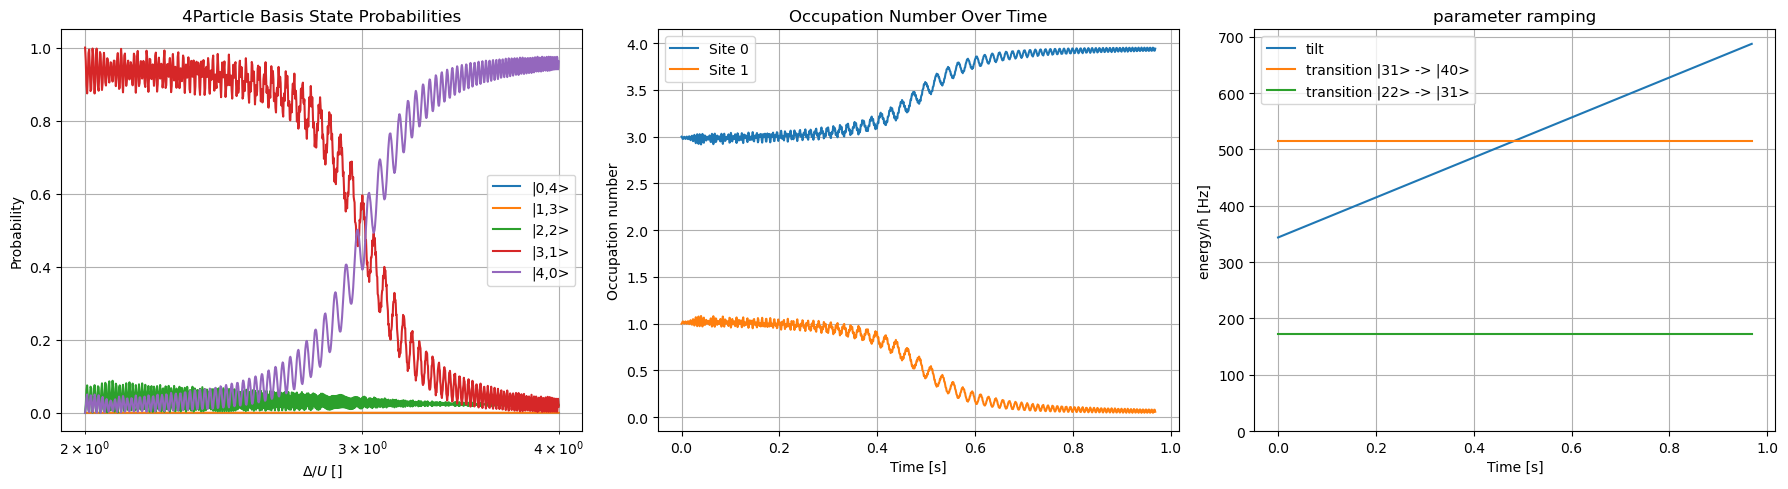

In [129]:
n = 4

initial_occ=np.array([n-1,1])

#maximum energy scale for ramp
#assuming that staying below 25% of the 1st excited state is enough
#and the contact scattering length can be tuned from 0 to 3.5* 85a0
limits = np.array([E_exc[0]/10,
                   E_barr[0]/10,
                   U_s[0]*3.5 + np.max(U_dds)])
E_max = np.min(limits)/const.hbar

# --- Parameters ---
J_freq = J[0]/const.hbar      # Hopping amplitude
U = (E_max/n, E_max/n)       # On-site interaction strength
Delta = ((n-2)*U[0], n*U[0])        #tilt

mu = 0.0      # Chemical potential (set to zero for simplicity)
# V = V_lrs.max()/const.hbar    # nearest neighbour interaction energy (due to DDI)
# DeltaJ = DeltaJs.max()/const.hbar   # density induced tunneling
V = 0
DeltaJ = 0

tau = 2*np.pi/J_freq *10    #take 10 times the time scale set by J for evolution
N_steps = int(1e3)      #number of timesteps

print(f"d: {distance[0]/si.nm:.2f} nm")
print(f"omega_x: {frequencies[0]/2/np.pi:.2f} Hz")
print(f"J: {J_freq/2/np.pi:.2f} Hz")
print(f"limits set by: 1st excited state = {limits[0]/const.h:.2f} Hz, barrier = {limits[1]/const.h:.2f} Hz, interactions = {limits[2]/const.h:.2f} Hz")
print(f"=> max. tilt/interaction: {E_max/2/np.pi:.2f} Hz")
print(f"J/U = {J_freq/U[0]:.4f}")
print(f"V: {V/2/np.pi:.2f} Hz")
print(f"DeltaJ: {DeltaJ/2/np.pi:.2f} Hz")
print(f"ramp time: {tau/si.ms:.3f} ms")

tlist, result = solve_hub(J_freq,U,Delta, mu,V,DeltaJ,tau,N_steps=N_steps,
                          initial_occ=initial_occ)

d= n + 1

# --- Extracting and Plotting State Vector Components ---
# Create an array of states; each state is flattened into a 1D array of length d^2
states = np.array([state.full().flatten() for state in result.states])
# Compute probabilities: squared magnitude of each component
probs = np.abs(states)**2

# Create labels for each basis state in the two-site Fock space
basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
# Create a list of corresponding total particle numbers for each basis state
total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

# Filter indices for basis states with exactly 2 particles
indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == np.sum(initial_occ)]
labels_2particles = [basis_labels[idx] for idx in indices_2particles]

#fidelity as the probability for |2,0> in the last 10% of steps
#calculate fidelity
fid  = np.mean(probs[int(0.9*len(tlist)):,indices_2particles[-1]])
print(f"fidelity: {fid:.5f}")

#alternatively with ratio Delta/U
interactions = np.linspace(U[0],U[1],len(tlist))
tilt = np.linspace(Delta[0],Delta[1],len(tlist))
ratio = tilt/interactions

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Probability of 2-particle basis states ---
for idx, label in zip(indices_2particles, labels_2particles):
    axs[0].plot(ratio[:int(1*len(tlist))], probs[:, idx][:int(1*len(tlist))], label=label)
axs[0].set_xscale("log")
axs[0].set_xlabel(r'$\Delta /U$ []')
axs[0].set_ylabel('Probability')
axs[0].set_title(f'{n}Particle Basis State Probabilities')
axs[0].legend()
axs[0].grid(which="both")

# --- Plot 2: Occupation number vs time ---
axs[1].plot(tlist, result.expect[0], label='Site 0')
axs[1].plot(tlist, result.expect[1], label='Site 1')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Occupation number')
axs[1].set_title('Occupation Number Over Time')
axs[1].legend()
axs[1].grid(True)

# --- Plot 3: Energies vs time ---
axs[2].plot(tlist, np.linspace(Delta[0]/2/np.pi, Delta[1]/2/np.pi, N_steps), label="tilt")

axs[2].plot(tlist, (6*U[0] - 3*U[0])/2/np.pi*np.ones(N_steps), label="transition |31> -> |40>")
axs[2].plot(tlist, (3*U[0] - 2*U[0])/2/np.pi*np.ones(N_steps), label="transition |22> -> |31>")

axs[2].set_ylim(bottom=0)
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('energy/h [Hz]')
axs[2].set_title('parameter ramping')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


## N=5

d: 745.43 nm
omega_x: 50000.00 Hz
J: 10.33 Hz
limits set by: 1st excited state = 687.56 Hz, barrier = 4053.51 Hz, interactions = 4310.78 Hz
=> max. tilt/interaction: 687.56 Hz
J/U = 0.0751
V: 0.00 Hz
DeltaJ: 0.00 Hz
ramp time: 968.363 ms
fidelity: 0.91652


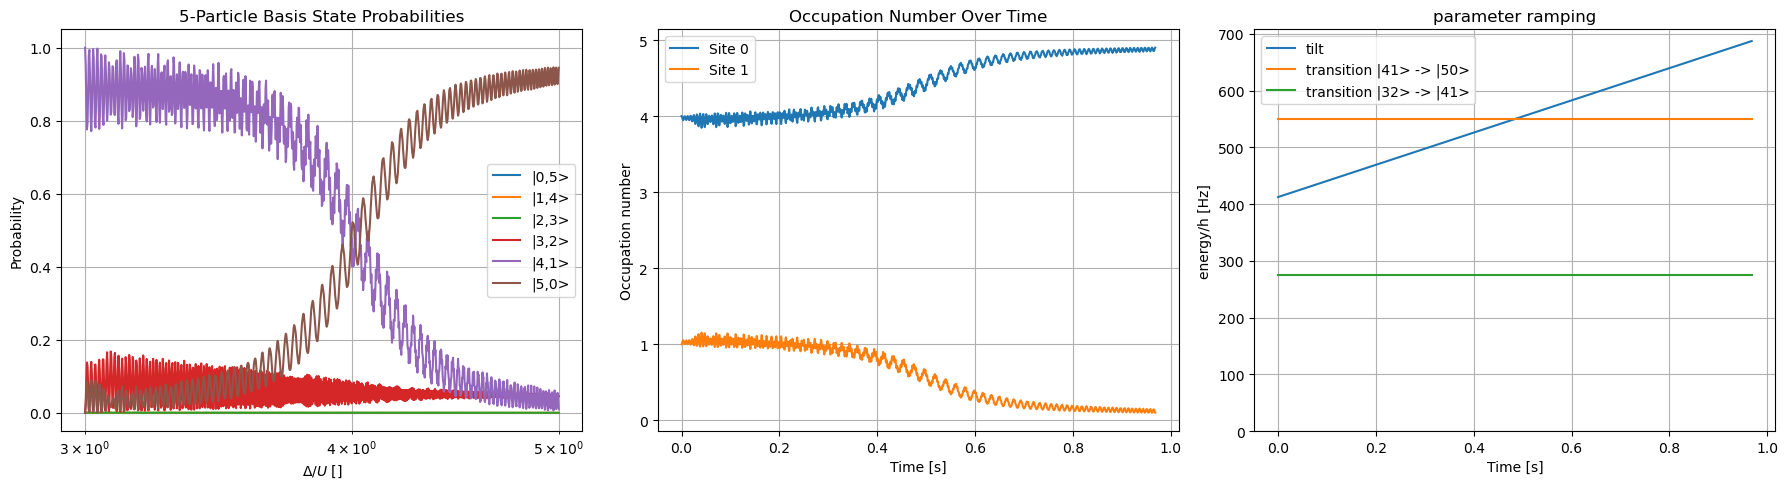

In [130]:
n = 5

initial_occ=np.array([n-1,1])

#maximum energy scale for ramp
#assuming that staying below 25% of the 1st excited state is enough
#and the contact scattering length can be tuned from 0 to 3.5* 85a0
limits = np.array([E_exc[0]/10,
                   E_barr[0]/10,
                   U_s[0]*3.5 + np.max(U_dds)])
E_max = np.min(limits)/const.hbar

# --- Parameters ---
J_freq = J[0]/const.hbar      # Hopping amplitude
U = (E_max/n, E_max/n)       # On-site interaction strength
Delta = ((n-2)*U[0], n*U[0])        #tilt

mu = 0.0      # Chemical potential (set to zero for simplicity)
# V = V_lrs.max()/const.hbar    # nearest neighbour interaction energy (due to DDI)
# DeltaJ = DeltaJs.max()/const.hbar   # density induced tunneling
V = 0
DeltaJ = 0

tau = 2*np.pi/J_freq *10    #take 10 times the time scale set by J for evolution
N_steps = int(1e3)      #number of timesteps

print(f"d: {distance[0]/si.nm:.2f} nm")
print(f"omega_x: {frequencies[0]/2/np.pi:.2f} Hz")
print(f"J: {J_freq/2/np.pi:.2f} Hz")
print(f"limits set by: 1st excited state = {limits[0]/const.h:.2f} Hz, barrier = {limits[1]/const.h:.2f} Hz, interactions = {limits[2]/const.h:.2f} Hz")
print(f"=> max. tilt/interaction: {E_max/2/np.pi:.2f} Hz")
print(f"J/U = {J_freq/U[0]:.4f}")
print(f"V: {V/2/np.pi:.2f} Hz")
print(f"DeltaJ: {DeltaJ/2/np.pi:.2f} Hz")
print(f"ramp time: {tau/si.ms:.3f} ms")

tlist, result = solve_hub(J_freq,U,Delta, mu,V,DeltaJ,tau,N_steps=N_steps,
                          initial_occ=initial_occ)

d= n + 1

# --- Extracting and Plotting State Vector Components ---
# Create an array of states; each state is flattened into a 1D array of length d^2
states = np.array([state.full().flatten() for state in result.states])
# Compute probabilities: squared magnitude of each component
probs = np.abs(states)**2

# Create labels for each basis state in the two-site Fock space
basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
# Create a list of corresponding total particle numbers for each basis state
total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

# Filter indices for basis states with exactly 2 particles
indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == np.sum(initial_occ)]
labels_2particles = [basis_labels[idx] for idx in indices_2particles]

#fidelity as the probability for |2,0> in the last 10% of steps
#calculate fidelity
fid  = np.mean(probs[int(0.9*len(tlist)):,indices_2particles[-1]])
print(f"fidelity: {fid:.5f}")

#alternatively with ratio Delta/U
interactions = np.linspace(U[0],U[1],len(tlist))
tilt = np.linspace(Delta[0],Delta[1],len(tlist))
ratio = tilt/interactions

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Probability of 2-particle basis states ---
for idx, label in zip(indices_2particles, labels_2particles):
    axs[0].plot(ratio[:int(1*len(tlist))], probs[:, idx][:int(1*len(tlist))], label=label)
axs[0].set_xscale("log")
axs[0].set_xlabel(r'$\Delta /U$ []')
axs[0].set_ylabel('Probability')
axs[0].set_title(f'{n}-Particle Basis State Probabilities')
axs[0].legend()
axs[0].grid(which="both")

# --- Plot 2: Occupation number vs time ---
axs[1].plot(tlist, result.expect[0], label='Site 0')
axs[1].plot(tlist, result.expect[1], label='Site 1')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Occupation number')
axs[1].set_title('Occupation Number Over Time')
axs[1].legend()
axs[1].grid(True)

# --- Plot 3: Energies vs time ---
axs[2].plot(tlist, np.linspace(Delta[0]/2/np.pi, Delta[1]/2/np.pi, N_steps), label="tilt")

axs[2].plot(tlist, (10*U[0] - 6*U[0])/2/np.pi*np.ones(N_steps), label="transition |41> -> |50>")
axs[2].plot(tlist, (6*U[0] - 4*U[0])/2/np.pi*np.ones(N_steps), label="transition |32> -> |41>")

axs[2].set_ylim(bottom=0)
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('energy/h [Hz]')
axs[2].set_title('parameter ramping')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


## N=6

d: 745.43 nm
omega_x: 50000.00 Hz
J: 10.33 Hz
limits set by: 1st excited state = 687.56 Hz, barrier = 4053.51 Hz, interactions = 4310.78 Hz
=> max. tilt/interaction: 687.56 Hz
J/U = 0.0901
V: 0.00 Hz
DeltaJ: 0.00 Hz
ramp time: 968.363 ms
fidelity: 0.86706


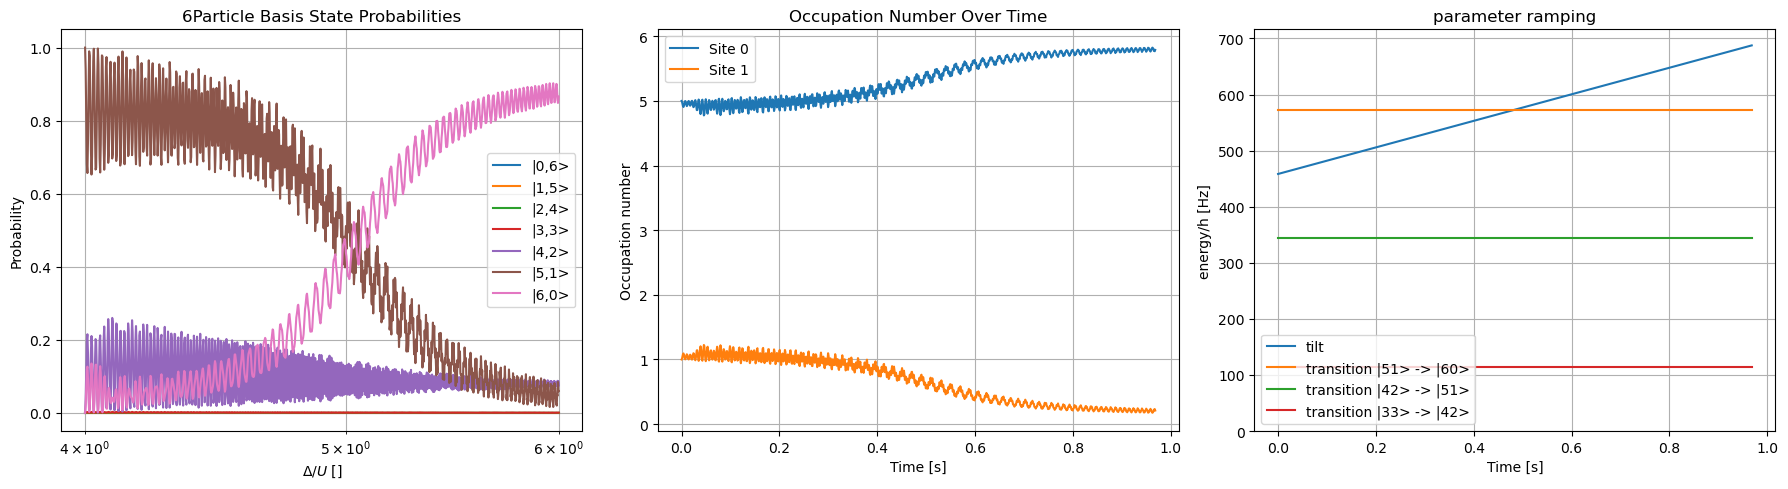

In [134]:
n = 6

initial_occ=np.array([n-1,1])

#maximum energy scale for ramp
#assuming that staying below 25% of the 1st excited state is enough
#and the contact scattering length can be tuned from 0 to 3.5* 85a0
limits = np.array([E_exc[0]/10,
                   E_barr[0]/10,
                   U_s[0]*3.5 + np.max(U_dds)])
E_max = np.min(limits)/const.hbar

# --- Parameters ---
J_freq = J[0]/const.hbar      # Hopping amplitude
U = (E_max/n, E_max/n)       # On-site interaction strength
Delta = ((n-2)*U[0], n*U[0])        #tilt

mu = 0.0      # Chemical potential (set to zero for simplicity)
# V = V_lrs.max()/const.hbar    # nearest neighbour interaction energy (due to DDI)
# DeltaJ = DeltaJs.max()/const.hbar   # density induced tunneling
V = 0
DeltaJ = 0

tau = 2*np.pi/J_freq *10    #take 10 times the time scale set by J for evolution
N_steps = int(1e3)      #number of timesteps

print(f"d: {distance[0]/si.nm:.2f} nm")
print(f"omega_x: {frequencies[0]/2/np.pi:.2f} Hz")
print(f"J: {J_freq/2/np.pi:.2f} Hz")
print(f"limits set by: 1st excited state = {limits[0]/const.h:.2f} Hz, barrier = {limits[1]/const.h:.2f} Hz, interactions = {limits[2]/const.h:.2f} Hz")
print(f"=> max. tilt/interaction: {E_max/2/np.pi:.2f} Hz")
print(f"J/U = {J_freq/U[0]:.4f}")
print(f"V: {V/2/np.pi:.2f} Hz")
print(f"DeltaJ: {DeltaJ/2/np.pi:.2f} Hz")
print(f"ramp time: {tau/si.ms:.3f} ms")

tlist, result = solve_hub(J_freq,U,Delta, mu,V,DeltaJ,tau,N_steps=N_steps,
                          initial_occ=initial_occ)

d= n + 1

# --- Extracting and Plotting State Vector Components ---
# Create an array of states; each state is flattened into a 1D array of length d^2
states = np.array([state.full().flatten() for state in result.states])
# Compute probabilities: squared magnitude of each component
probs = np.abs(states)**2

# Create labels for each basis state in the two-site Fock space
basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
# Create a list of corresponding total particle numbers for each basis state
total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

# Filter indices for basis states with exactly 2 particles
indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == np.sum(initial_occ)]
labels_2particles = [basis_labels[idx] for idx in indices_2particles]

#fidelity as the probability for |2,0> in the last 10% of steps
#calculate fidelity
fid  = np.mean(probs[int(0.9*len(tlist)):,indices_2particles[-1]])
print(f"fidelity: {fid:.5f}")

#alternatively with ratio Delta/U
interactions = np.linspace(U[0],U[1],len(tlist))
tilt = np.linspace(Delta[0],Delta[1],len(tlist))
ratio = tilt/interactions

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Probability of 2-particle basis states ---
for idx, label in zip(indices_2particles, labels_2particles):
    axs[0].plot(ratio[:int(1*len(tlist))], probs[:, idx][:int(1*len(tlist))], label=label)
axs[0].set_xscale("log")
axs[0].set_xlabel(r'$\Delta /U$ []')
axs[0].set_ylabel('Probability')
axs[0].set_title(f'{n}Particle Basis State Probabilities')
axs[0].legend()
axs[0].grid(which="both")

# --- Plot 2: Occupation number vs time ---
axs[1].plot(tlist, result.expect[0], label='Site 0')
axs[1].plot(tlist, result.expect[1], label='Site 1')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Occupation number')
axs[1].set_title('Occupation Number Over Time')
axs[1].legend()
axs[1].grid(True)

# --- Plot 3: Energies vs time ---
axs[2].plot(tlist, np.linspace(Delta[0]/2/np.pi, Delta[1]/2/np.pi, N_steps), label="tilt")

axs[2].plot(tlist, (15*U[0] - 10*U[0])/2/np.pi*np.ones(N_steps), label="transition |51> -> |60>")
axs[2].plot(tlist, (10*U[0] - 7*U[0])/2/np.pi*np.ones(N_steps), label="transition |42> -> |51>")
axs[2].plot(tlist, (7*U[0] - 6*U[0])/2/np.pi*np.ones(N_steps), label="transition |33> -> |42>")

axs[2].set_ylim(bottom=0)
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('energy/h [Hz]')
axs[2].set_title('parameter ramping')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


# Automatically find ramp range:

N = 2
[1 1]
fidelity: 0.99184


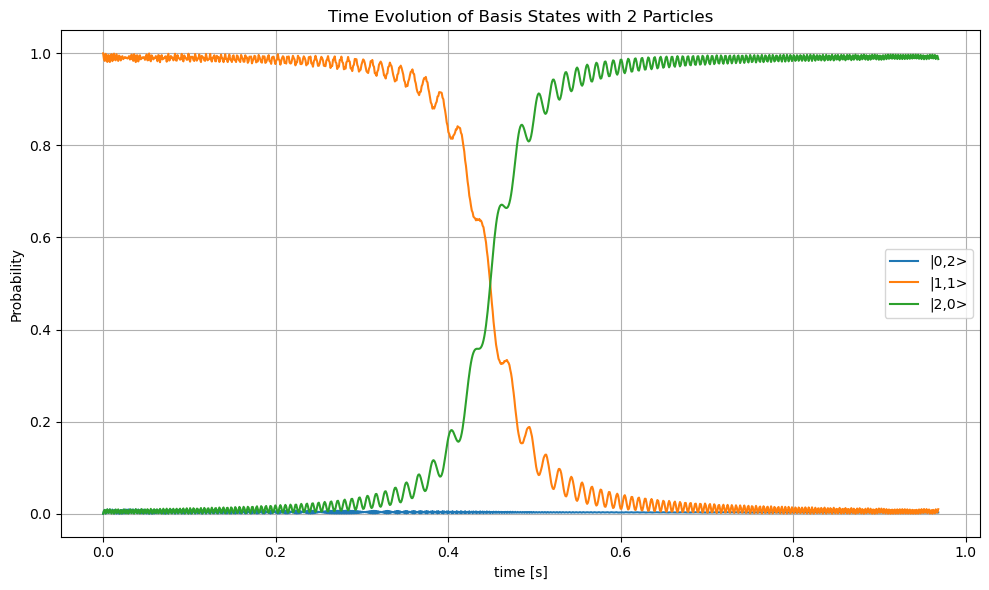

N = 3
[2 1]
fidelity: 0.96524


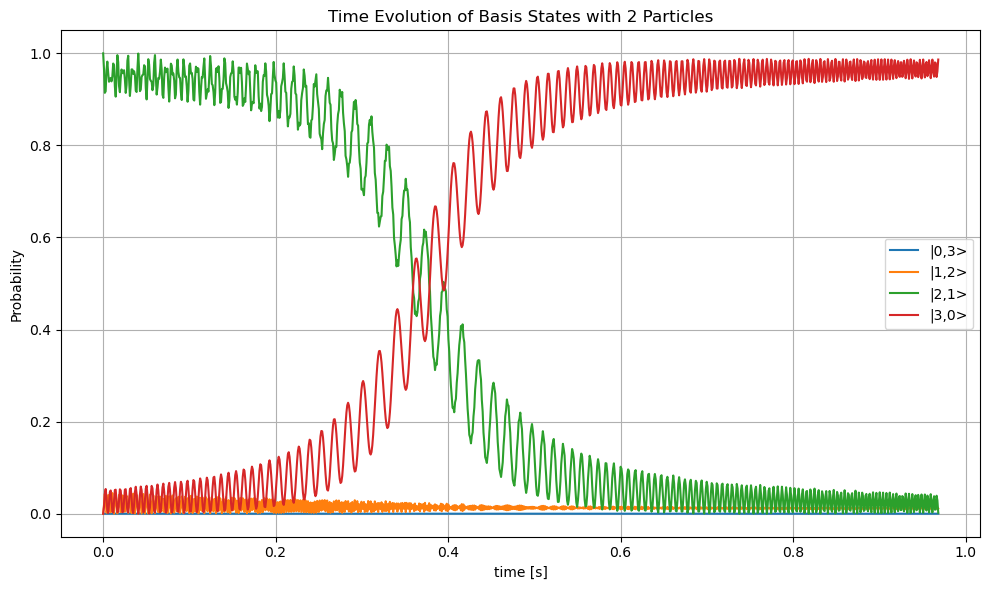

N = 4
[3 1]
fidelity: 0.88922


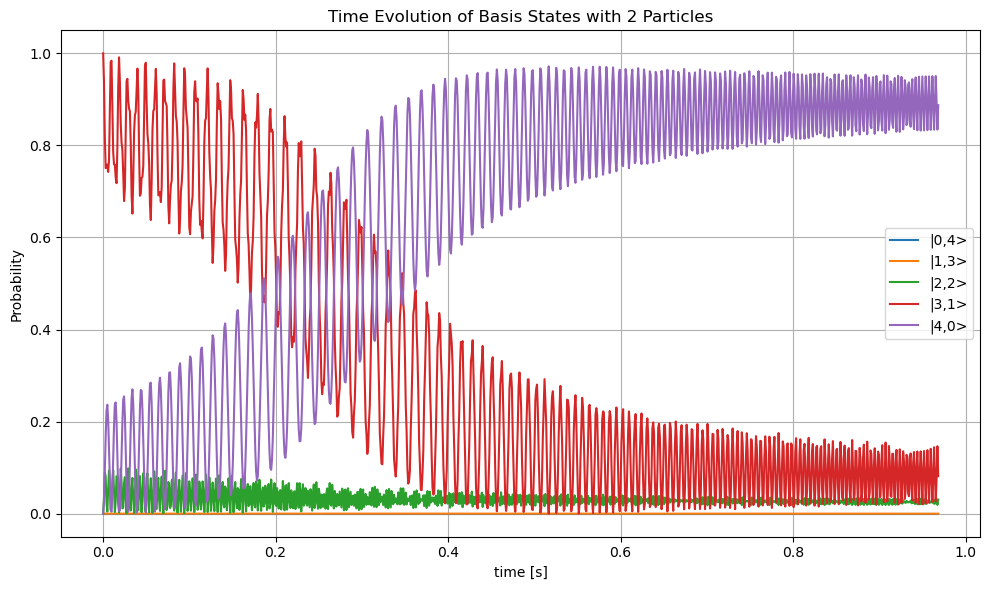

N = 5
[4 1]
fidelity: 0.67585


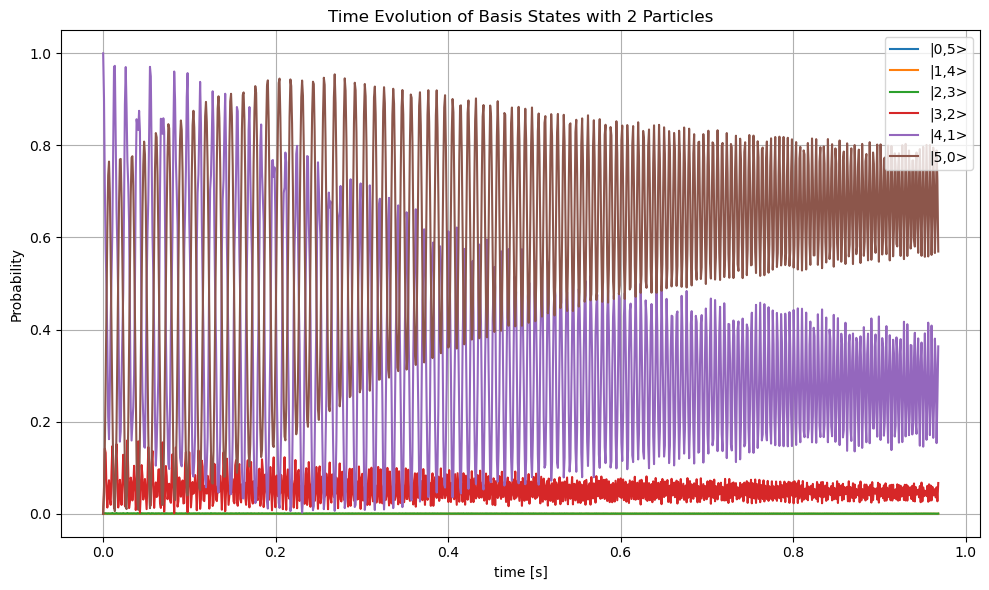

N = 6
[5 1]
fidelity: 0.40636


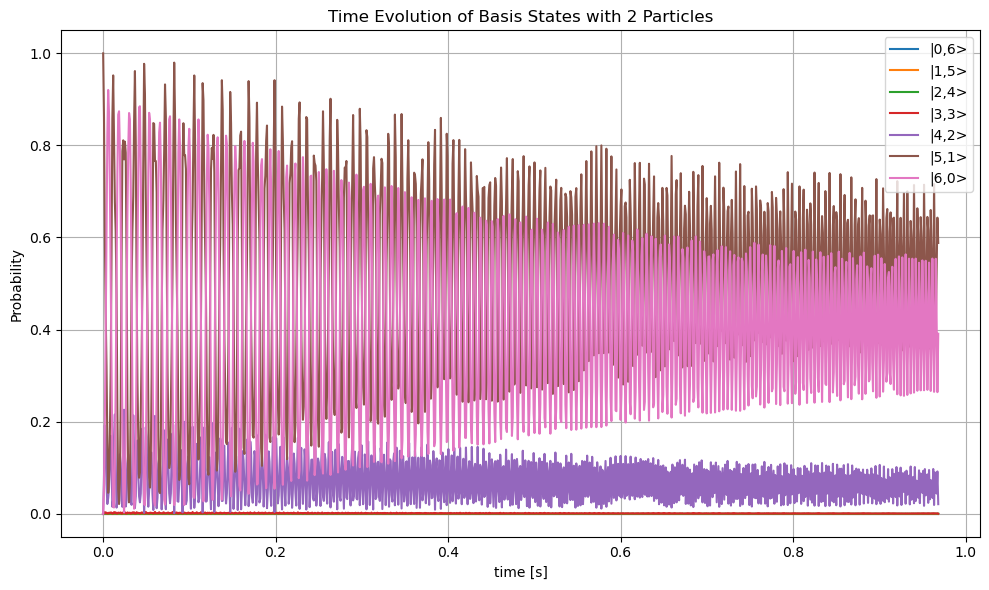

N = 7
[6 1]
fidelity: 0.26617


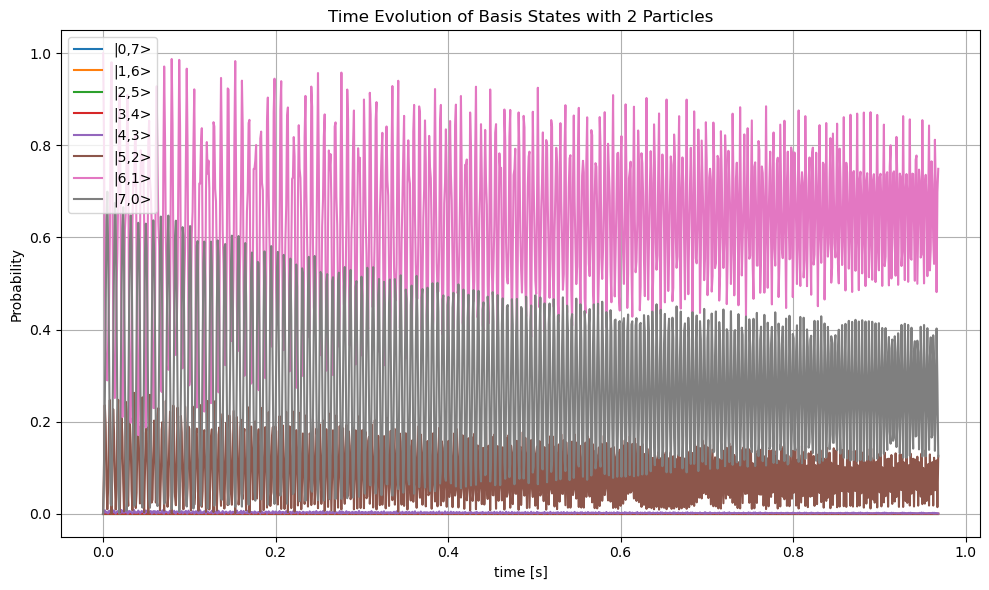

N = 8
[7 1]
fidelity: 0.20995


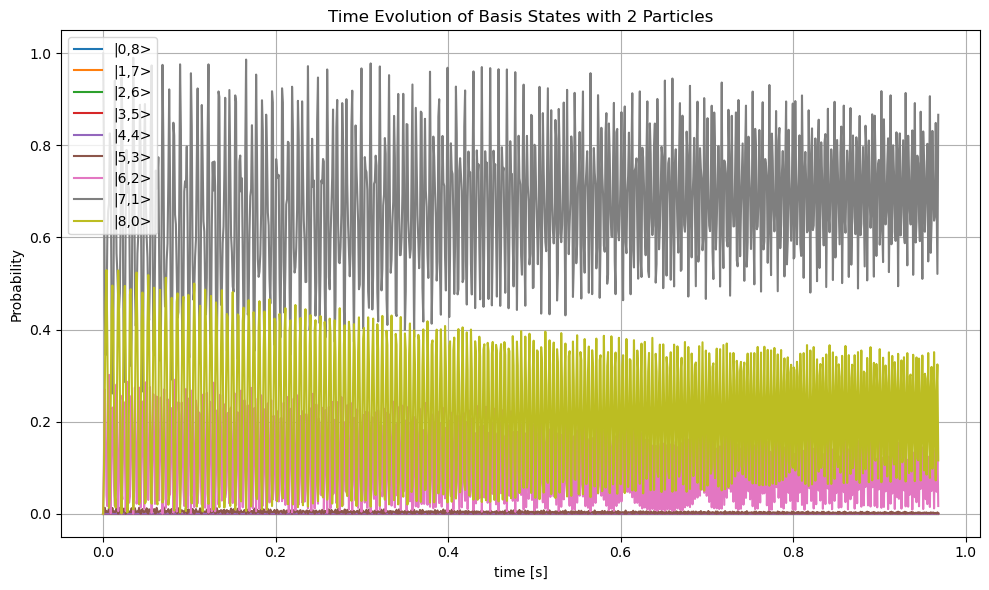

In [87]:
N = np.arange(2,9)

for n in N:
    print(f"N = {n}")

    initial_occ=np.array([n-1,1])
    print(initial_occ)

    #maximum energy scale for ramp
    #assuming that staying below 25% of the 1st excited state is enough
    #and the contact scattering length can be tuned from 0 to 3.5* 85a0
    limits = np.array([E_exc[0]/10,
                    E_barr[0]/10,
                    U_s[0]*3.5 + np.max(U_dds)])
    E_max = np.min(limits)/const.hbar

    # --- Parameters ---
    J_freq = J[0]/const.hbar      # Hopping amplitude
    U = (E_max/n, E_max/n)       # On-site interaction strength
    Delta = ((n-2)*U[0], n*U[0])        #tilt

    mu = 0.0      # Chemical potential (set to zero for simplicity)
    V = V_lrs.max()/const.hbar    # nearest neighbour interaction energy (due to DDI)
    DeltaJ = DeltaJs.max()/const.hbar   # density induced tunneling
    # V = 0
    # DeltaJ = 0

    tau = 2*np.pi/J_freq *10    #take 10 times the time scale set by J for evolution
    N_steps = int(1e3)      #number of timesteps

    #solve hamiltonian
    tlist, result = solve_hub(J_freq,U,Delta, mu,V,DeltaJ,tau,N_steps=N_steps,
                            initial_occ=initial_occ)
    
    d=n + 1

    # --- Extracting and Plotting State Vector Components ---
    # Create an array of states; each state is flattened into a 1D array of length d^2
    states = np.array([state.full().flatten() for state in result.states])
    # --- Extracting and Plotting State Vector Components ---
    # Compute probabilities: squared magnitude of each component
    probs = np.abs(states)**2

    # Create labels for each basis state in the two-site Fock space
    basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
    # Create a list of corresponding total particle numbers for each basis state
    total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

    # Filter indices for basis states with exactly 2 particles
    indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == np.sum(initial_occ)]
    labels_2particles = [basis_labels[idx] for idx in indices_2particles]

    #calculate fidelity
    fid  = np.mean(probs[int(0.9*len(tlist)):,indices_2particles[-1]])
    print(f"fidelity: {fid:.5f}")
    

    # Plot the probability for each 2-particle basis state over time
    plt.figure(figsize=(10, 6))
    for idx, label in zip(indices_2particles, labels_2particles):
        plt.plot(tlist, probs[:, idx], label=label)
    plt.xlabel(r'time [s]')
    plt.ylabel('Probability')
    plt.title('Time Evolution of Basis States with 2 Particles')
    plt.legend()
    plt.grid(which="both")
    plt.tight_layout()
    plt.show()

N = 2
[1 1]


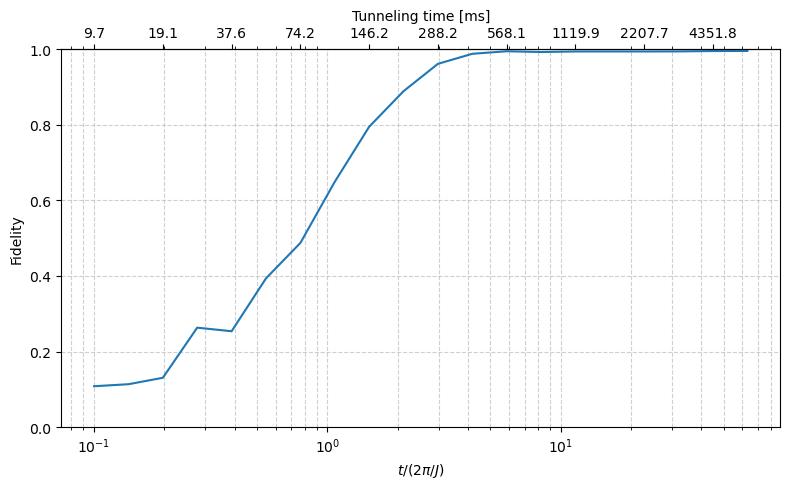

N = 3
[2 1]


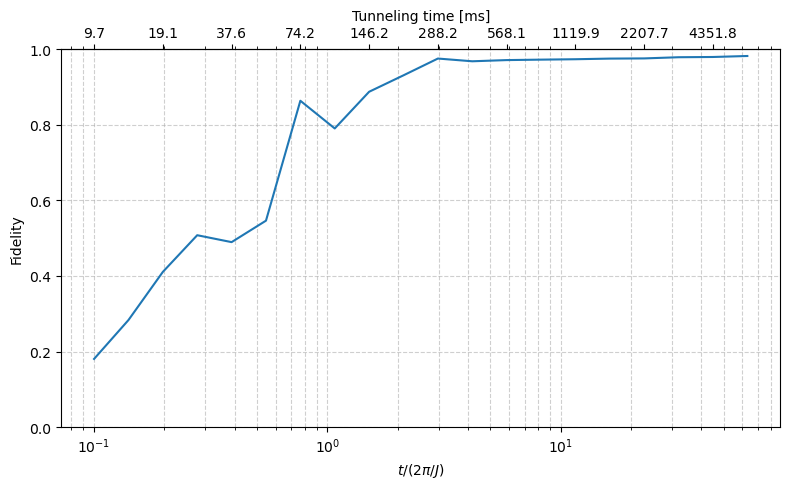

N = 4
[3 1]


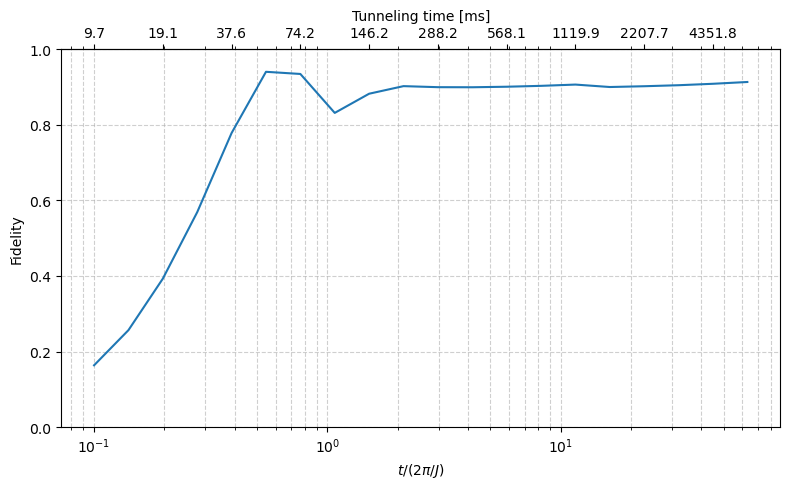

N = 5
[4 1]


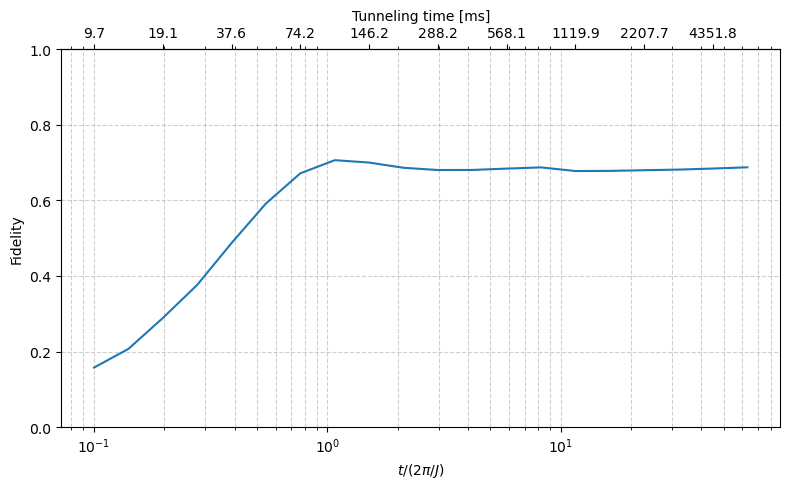

N = 6
[5 1]


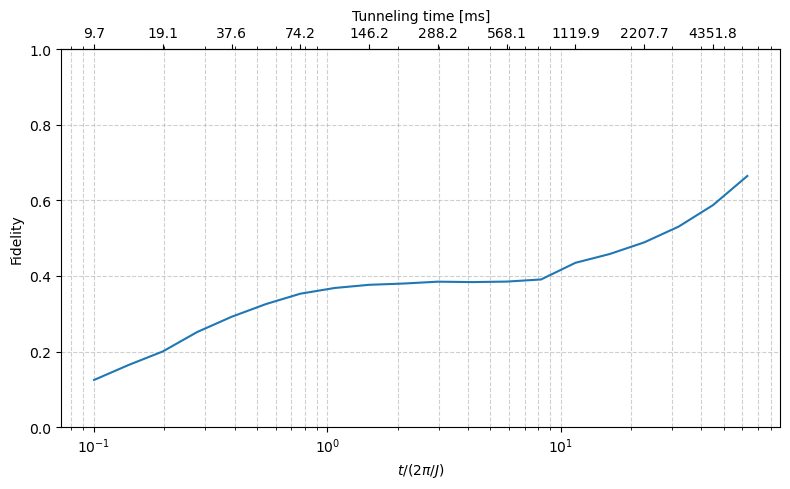

N = 7
[6 1]


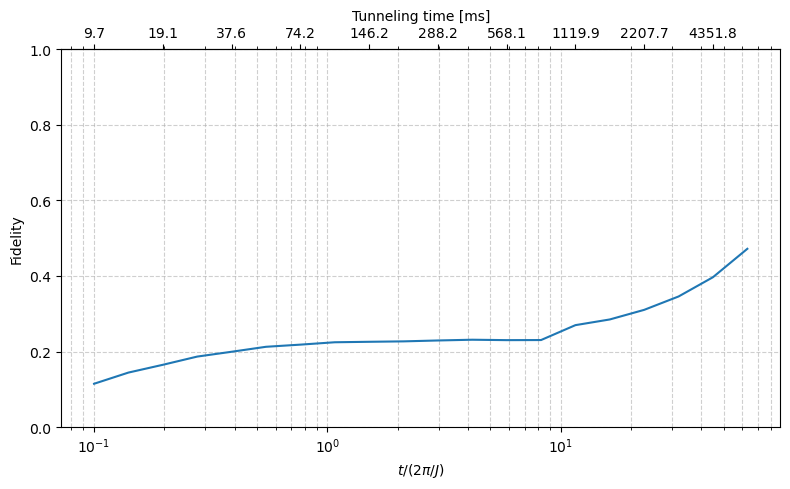

N = 8
[7 1]


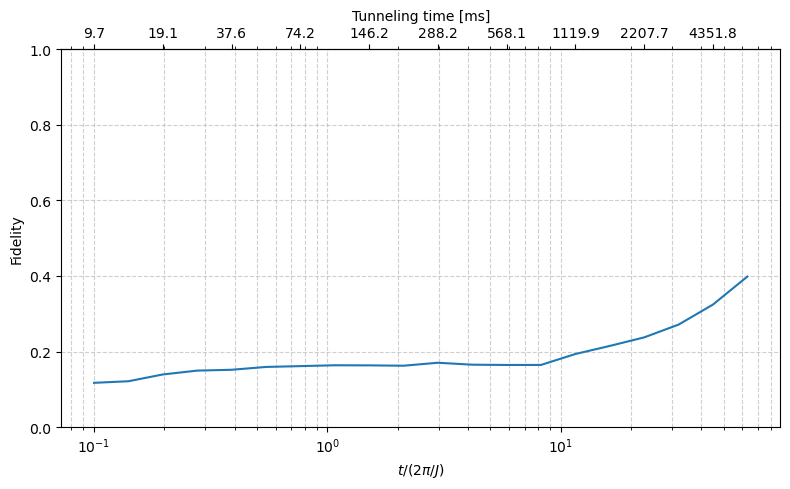

In [135]:
N = np.arange(2,9)

fidelity_n = np.zeros(len(N))
tunneling_time_n = np.zeros(len(N))

for j, n in enumerate(N):
    print(f"N = {n}")

    initial_occ=np.array([n-1,1])
    print(initial_occ)

    tunneling_factor = np.logspace(-1,1.8,20)
    tunneling_time = np.zeros_like(tunneling_factor)
    fidelity = np.zeros_like(tunneling_factor)

    for i, fac in enumerate(tunneling_factor):
        #maximum energy scale for ramp
        #assuming that staying below 25% of the 1st excited state is enough
        #and the contact scattering length can be tuned from 0 to 3.5* 85a0
        limits = np.array([E_exc[0]/10,
                        E_barr[0]/10,
                        U_s[0]*3.5 + np.max(U_dds)])
        E_max = np.min(limits)/const.hbar

        # --- Parameters ---
        J_freq = J[0]/const.hbar      # Hopping amplitude
        U = (E_max/n, 0*E_max/n)       # On-site interaction strength
        Delta = ((n-2)*U[0], n*U[0])        #tilt

        mu = 0.0      # Chemical potential (set to zero for simplicity)
        V = V_lrs.max()/const.hbar    # nearest neighbour interaction energy (due to DDI)
        DeltaJ = DeltaJs.max()/const.hbar   # density induced tunneling
        # V = 0
        # DeltaJ = 0

        tau = 2*np.pi/J_freq *fac    #take 10 times the time scale set by J for evolution
        N_steps = int(1e3)      #number of timesteps

        # print(f"J: {J_freq/2/np.pi:.2f} Hz")
        # print(f"max. tilt: {E_max/2/np.pi:.2f} Hz, {limits/const.h}")
        # print(f"V: {V/2/np.pi:.2f} Hz")
        # print(f"DeltaJ: {DeltaJ/2/np.pi:.2f} Hz")
        # print(f"ramp time: {tau/si.ms:.3f} ms")

        tlist, result = solve_hub(J_freq,U,Delta, mu,V,DeltaJ,tau,N_steps=N_steps,
                                  initial_occ=initial_occ)

        d=n + 1
        # --- Extracting and Plotting State Vector Components ---
        # Create an array of states; each state is flattened into a 1D array of length d^2
        states = np.array([state.full().flatten() for state in result.states])
        # --- Extracting and Plotting State Vector Components ---
        # Compute probabilities: squared magnitude of each component
        probs = np.abs(states)**2
        # Create labels for each basis state in the two-site Fock space
        basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
        # Create a list of corresponding total particle numbers for each basis state
        total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

        # Filter indices for basis states with exactly 2 particles
        indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == np.sum(initial_occ)]
        labels_2particles = [basis_labels[idx] for idx in indices_2particles]

        #calculate fidelity
        fid  = np.mean(probs[int(0.9*len(tlist)):,indices_2particles[-1]])

        tunneling_time[i] = tau
        fidelity[i] = fid


    #maximum fidelity is at longest ramp time
    fidelity_n[j] = fidelity[-1]
    #find minimal tunneling time
    mask = abs(fidelity - fidelity[-1]) < 0.01
    tunneling_time_n[j] = np.min(tunneling_time[mask])


    # Main plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(tunneling_factor, fidelity)
    ax.set_xscale("log")
    ax.set_ylim(0,1)
    ax.set_xlabel(r"$t/(2\pi/J)$")
    ax.set_ylabel("Fidelity")
    ax.grid(True, which="both", linestyle="--", alpha=0.6)

    # Add top axis with tick locations from tunneling_factor and labels from tunneling_time
    secax = ax.secondary_xaxis('top')
    secax.set_xticks(tunneling_factor[::2])
    secax.set_xticklabels([f"{t*1e3:.1f}" for t in tunneling_time[::2]])
    secax.set_xlabel("Tunneling time [ms]")

    plt.tight_layout()
    plt.show()

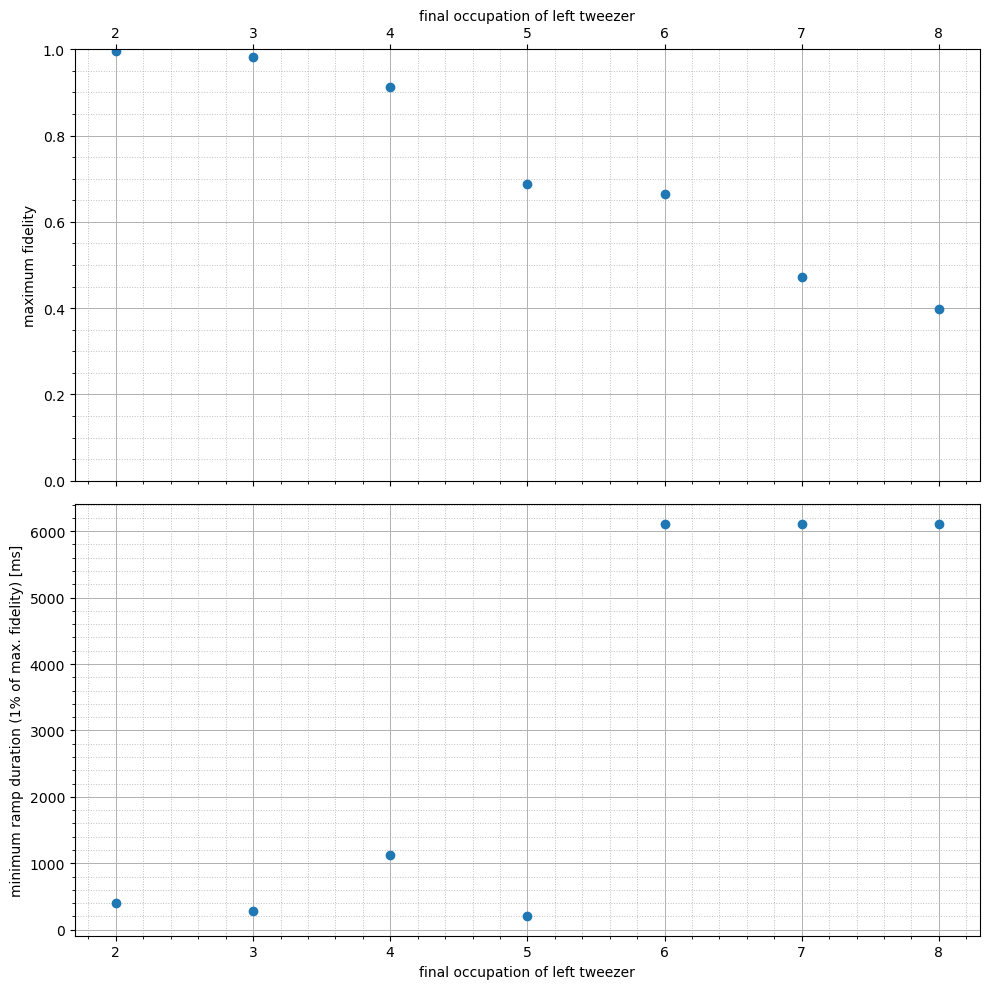

In [136]:
# Create a figure with 4 subplots (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

axes[0].plot(N, fidelity_n,"o")
#axes[0].set_yscale("log")
axes[0].set_ylim(0,1)
axes[0].set_ylabel("maximum fidelity")
axes[0].xaxis.set_label_position('top')
axes[0].set_xlabel("final occupation of left tweezer")
#axes[0].legend()
# 🔹 Add top x-axis ticks
axes[0].tick_params(axis="x", labeltop=True, top=True)
axes[0].grid(True, linestyle='-', linewidth=0.7)
axes[0].minorticks_on()
axes[0].grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=0.8)


axes[1].plot(N, tunneling_time_n/si.ms,"o")
axes[1].set_ylabel("minimum ramp duration (1% of max. fidelity) [ms]")
axes[1].set_xlabel("final occupation of left tweezer")
#axes[1].legend()
axes[1].grid(True, linestyle='-', linewidth=0.7)
axes[1].minorticks_on()
axes[1].grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=0.8)

plt.tight_layout()
plt.show()

Going really slowly seems to somewhat negate the effect of tunneling from |n-1,1> to |n-2,2>